# SPI Momentum

Add a description of the project here, just a brief overview. Describe the context, datasets used, and key objectives

### Setup and Dependencies
Import Libraries: Create a separate cell for importing all the necessary libraries (e.g., pandas, numpy, matplotlib, etc.).
Import functions: Import all the necessary funcitons for data loading, backtesting, etc.
Set Environment Variable: 
Set cache directory (if needed):

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings

# Add the project root directory to sys.path
project_root = Path(os.getcwd()).resolve().parents[0] # strange, does that work for you too guys???
#DEBUG print(project_root)
sys.path.append(str(project_root))

# Load other funcitons
from src.analysis.load_data import load_data
from src.visualization.plotPerformance import plot_cumulative_returns
from src.visualization.plotRobustnessChecks import plotRobustnessChecks
from src.analysis.summarize_performance import summarize_performance, save_summary_to_latex
from src.analysis.momentum_strategy_backtest import momentum_strategy
from src.visualization.create_summary_table import create_summary_table

warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Import and Overview

Load data here and explain what the processing does

In [7]:
# Define the base path for file locations
base_path = project_root

# Construct file paths dynamically
constituents_data_path = base_path / "data" / "processed" / "constituents_data.csv"
rf_monthly_path = base_path / "data" / "processed" / "risk_free.csv"
results_path = base_path / "data" / "results"
spi_path = base_path / "data" / "processed" / "index_data.csv"
summary_file_path_longOnly = results_path / "summary_performance_longOnly.tex"
summary_file_path_longShort = results_path / "summary_performance_longShort.tex"
visualization_path = base_path / "reports" / "figures"

# Load financial data
rf_monthly = load_data(rf_monthly_path)
price_data_daily = load_data(constituents_data_path)
spi_price_daily = load_data(spi_path)
spi_price_monthly = spi_price_daily.resample('ME').last()

# Calculate Benchmark Returns and correct for massive outliers
spi_returns_monthly = spi_price_monthly.pct_change()
if isinstance(spi_returns_monthly, pd.Series):
    spi_returns_monthly = spi_returns_monthly.to_frame()
spi_returns_monthly = np.clip(spi_returns_monthly, -0.5, 0.5)
spi_XsReturns_monthly = spi_returns_monthly['SWISS PERFORMANCE INDEX - TOT RETURN IND'] - rf_monthly['monthly_return']
if isinstance(spi_XsReturns_monthly, pd.Series):
    spi_XsReturns_monthly = spi_XsReturns_monthly.to_frame()

# Rename Coluns for consistency
spi_XsReturns_monthly.columns = ['Benchmark']
spi_returns_monthly.columns = ['Benchmark']

### Set up Basic Parameters for Analysis

Since the project is fully reproducable, we decided to include the most important strategy paratemers on this level so that any potential future researcher can simply change the parameters for the analysis here. As a basic set up we chose to use the parameters as listed below. Of course, there will be rubustness checks for all those parameters at the end. 

In [10]:
lookback_period = 6    # Number of months to look back
holding_period = 6     # Number of months the assets will be held
nLong = 20             # Number of assets to go long
nShort = 20            # Number of assets to short
trx_cost = 0           # Transaction Costs (i.e. 0.01 = 1%)

### Momentum Analysis
Run the analysis code here and compare results to benchmark, show performance stats. etc., show Long and Long-Short + table with most important stats

Save the summarize performance plot to /Users/steve/Documents/Coding/my-project/SPI-Momentum/reports/figures/cumulative_returns


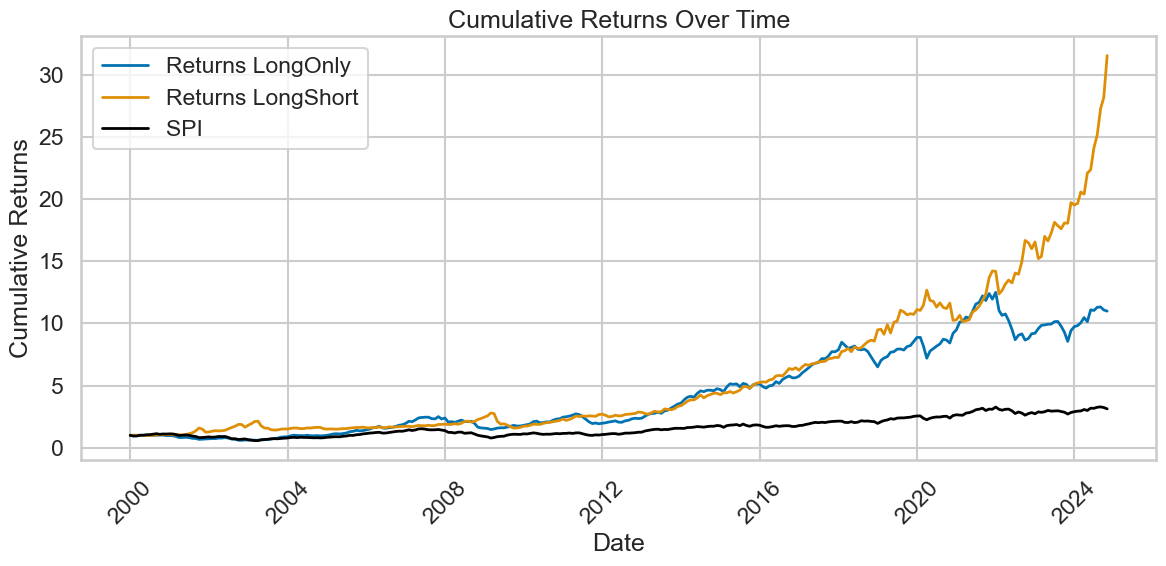

In [12]:
# ----- Execute Long only backtest -----
excess_returns_longOnly, portfolio_weights_longOnly, turnover_series_longOnly, portfolio_returns_longOnly = momentum_strategy(
    price_data_daily=price_data_daily,
    lookback_period=lookback_period,
    nLong=nLong,
    nShort=0,
    holding_period=holding_period,
    rf_monthly=rf_monthly,
    trx_cost=0
)
excess_returns_longOnly.columns = ['Xs Returns LongOnly']
portfolio_returns_longOnly.columns = ['Returns LongOnly']

# Save results, might delete the writing to csv???
excess_returns_longOnly.to_csv(results_path / "excess_returns_longOnly.csv", index=True, header=True)
portfolio_weights_longOnly.to_csv(results_path / "portfolio_weights_longOnly.csv", index=True, header=True)
turnover_series_longOnly.to_csv(results_path / "turnover_series_longOnly.csv", index=True, header=True)
stats_longOnly = summarize_performance(excess_returns_longOnly, rf_monthly, spi_XsReturns_monthly, 12)
save_summary_to_latex(stats_longOnly, summary_file_path_longOnly)

# ----- Execute Long / Short backtest -----
excess_returns_longShort, portfolio_weights_longShort, turnover_series_longShort, portfolio_returns_longShort = momentum_strategy(
    price_data_daily=price_data_daily,
    lookback_period=lookback_period,
    nLong=nLong,
    nShort=nShort,
    holding_period=holding_period,
    rf_monthly=rf_monthly,
    trx_cost=0
)
excess_returns_longShort.columns = ['Xs Returns LongShort']
portfolio_returns_longShort.columns = ['Returns LongShort']

# Save results, might delete the writing to csv???
excess_returns_longShort.to_csv(results_path / "excess_returns_longShort.csv", index=True, header=True)
portfolio_weights_longShort.to_csv(results_path / "portfolio_weights_longShort.csv", index=True, header=True)
turnover_series_longShort.to_csv(results_path / "turnover_series_longShort.csv", index=True, header=True)
stats_longShort = summarize_performance(excess_returns_longShort, rf_monthly, spi_XsReturns_monthly, 12)
save_summary_to_latex(stats_longShort, summary_file_path_longShort)


# Custom labels
labels = {
    'Strategy_Returns': 'Long Momentum Strategy',
    'Benchmark': 'SPI',
    'Portfolio_Returns': 'Long Momentum Strategy',
    'xs_Return': 'Long Momentum Strategy',
    'trx_cost_0.001': 'Strategy with Trx Cost: 0.1%',
    'trx_cost_0.005': 'Strategy with Trx Cost: 0.5%',
    'trx_cost_0.01': 'Strategy with Trx Cost: 1.0%',
}

# Create plot of cummulative returns against benchmark
combined_returns = pd.concat([portfolio_returns_longOnly, portfolio_returns_longShort], axis=1)
plot_cumulative_returns(combined_returns, spi_returns_monthly, labels,filename=visualization_path / "cumulative_returns")


In [13]:
# Table with stats:
create_summary_table([stats_longOnly, stats_longShort], ['Long Only', 'Long Short'])

#++ add benchmark data??? how

,Long Only,Long Short
Arithmetic_Avg_Total_Return,10.80,17.01
Arithmetic_Avg_Excess_Return,8.98,15.19
Geometric_Avg_Total_Return,10.10,16.94
Geometric_Avg_Excess_Return,8.26,15.11
Std_of_Excess_Returns_Annualized,0.15,0.16
Sharpe_Ratio_Arithmetic,0.59,0.96
Sharpe_Ratio_Geometric,0.54,0.96
Min_Excess_Return,-0.16,-0.23
Max_Excess_Return,0.10,0.16
Skewness_of_Excess_Return,-0.71,-0.87


### Robustness Checks
In this section we perform robustness checks over different input parameters that we have chosen "arbitrarily". Those parameters are lookback period, holding period, nLong/nShort, trx cost

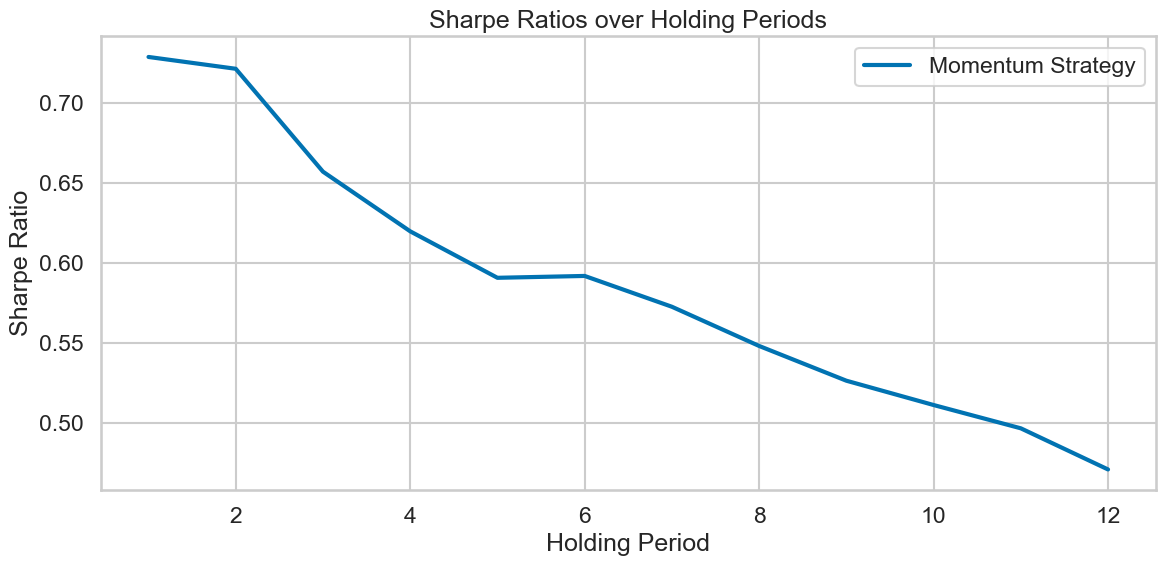

In [15]:
# Robustness check over holding period
# Loop over 1-12 months
rc_holding_period = pd.DataFrame(index=range(1, 13), columns=['Sharpe_Ratio'])
for i in range(1,13):
    excess_returnsTemp , _ , _, _ = momentum_strategy(
        price_data_daily=price_data_daily,
        lookback_period=lookback_period,
        nLong=nLong,
        nShort=0,
        holding_period=i,
        rf_monthly=rf_monthly,
        trx_cost=0
        )
    excess_returnsTemp.columns = ['Strategy_Returns']
    stats_temp = summarize_performance(excess_returnsTemp, rf_monthly, spi_XsReturns_monthly, 12)
    rc_holding_period.loc[i,'Sharpe_Ratio'] = stats_temp['Sharpe_Ratio_Arithmetic']['xs_Return']
    
plotRobustnessChecks(
    rc_holding_period,
    label = "Momentum Strategy",
    title='Sharpe Ratios over Holding Periods',
    x_label='Holding Period',
    y_label='Sharpe Ratio',
    savefig=True,
    filename=visualization_path / 'rc_holding_period.png'
)

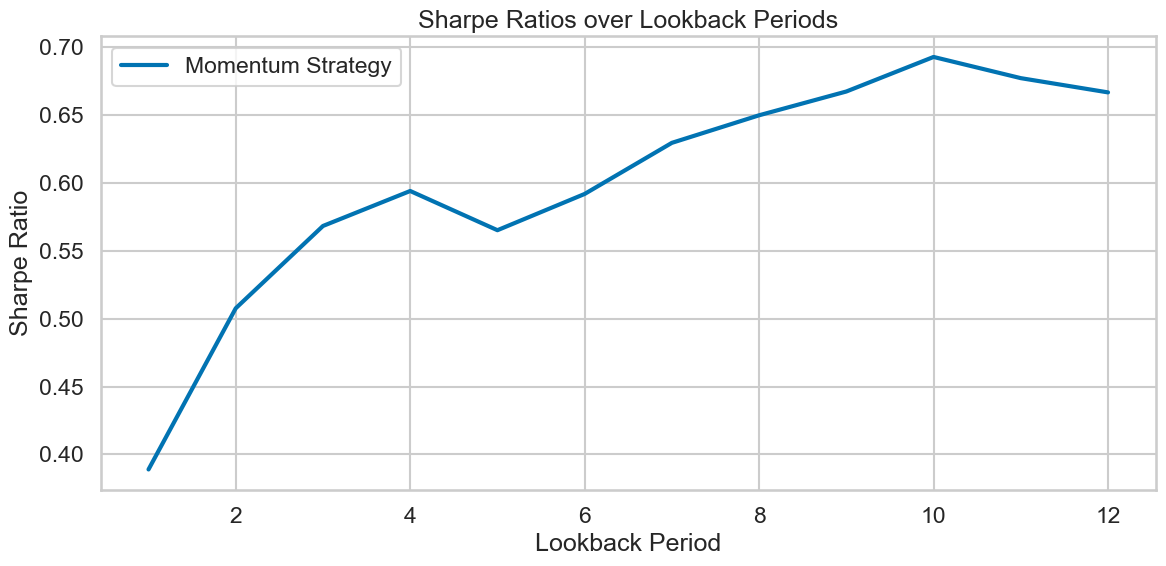

In [16]:
# Robustness check over lookback period
# Loop over 1-12
rc_lookback_period = pd.DataFrame(index=range(1, 13), columns=['Sharpe_Ratio'])
for i in range(1,13):
    excess_returnsTemp , _ , _, _ = momentum_strategy(
        price_data_daily=price_data_daily,
        lookback_period=i,
        nLong=nLong,
        nShort=0,
        holding_period=holding_period,
        rf_monthly=rf_monthly,
        trx_cost=0
        )
    excess_returnsTemp.columns = ['Strategy_Returns']
    stats_temp = summarize_performance(excess_returnsTemp, rf_monthly, spi_XsReturns_monthly, 12)
    rc_lookback_period.loc[i,'Sharpe_Ratio'] = stats_temp['Sharpe_Ratio_Arithmetic']['xs_Return']
    
plotRobustnessChecks(
    rc_lookback_period,
    label = "Momentum Strategy",
    title='Sharpe Ratios over Lookback Periods',
    x_label='Lookback Period',
    y_label='Sharpe Ratio',
    savefig=True,
    filename= visualization_path / 'rc_lookback_period.png'
)

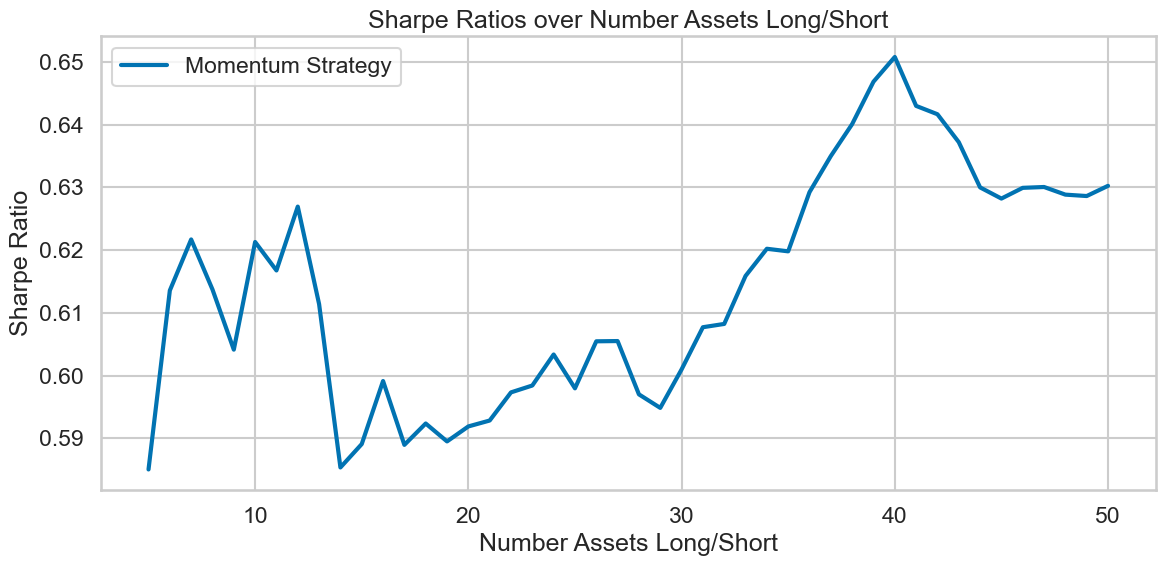

In [17]:
# Robustness check over number assets
# Loop over 5-50
rc_number_assets = pd.DataFrame(index=range(5, 51), columns=['Sharpe_Ratio'])
for i in range(5,51):
    excess_returnsTemp , _ , _, _ = momentum_strategy(
        price_data_daily=price_data_daily,
        lookback_period=lookback_period,
        nLong=i,
        nShort=0,
        holding_period=holding_period,
        rf_monthly=rf_monthly,
        trx_cost=0
        )
    excess_returnsTemp.columns = ['Strategy_Returns']
    stats_temp = summarize_performance(excess_returnsTemp, rf_monthly, spi_XsReturns_monthly, 12)
    rc_number_assets.loc[i,'Sharpe_Ratio'] = stats_temp['Sharpe_Ratio_Arithmetic']['xs_Return']
    
plotRobustnessChecks(
    rc_number_assets,
    label = "Momentum Strategy",
    title='Sharpe Ratios over Number Assets Long/Short',
    x_label='Number Assets Long/Short',
    y_label='Sharpe Ratio',
    savefig=True,
    filename=visualization_path / 'rc_number_assets.png'
)

Save the summarize performance plot to /Users/steve/Documents/Coding/my-project/SPI-Momentum/reports/figures/rc_trxCost.png


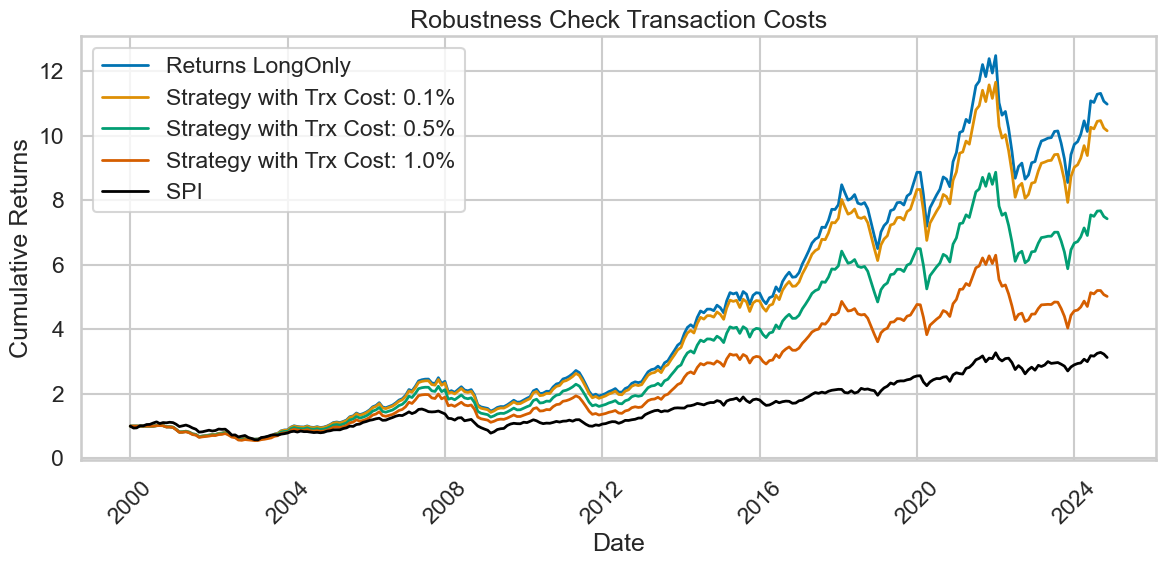

In [30]:
# Robustness checks over TRX cost
# Initialize the DataFrame to hold the results
rc_trxCost_returns = portfolio_returns_longOnly.copy()

# List of transaction costs
trxCosts = [0.001, 0.005, 0.01]

# Loop through transaction costs and add the new columns
for trx_cost in trxCosts:
    # Run the momentum strategy, here we need total ret not xs ret, for plot
    _, _, _, portfolio_returnsTemp = momentum_strategy(
        price_data_daily=price_data_daily,
        lookback_period=lookback_period,
        nLong=20,
        nShort=0,
        holding_period=holding_period,
        rf_monthly=rf_monthly,
        trx_cost=trx_cost
    )
    if isinstance(portfolio_returnsTemp, pd.Series):
        portfolio_returnsTemp = portfolio_returnsTemp.to_frame()
    portfolio_returnsTemp.columns = ['Strategy_Returns']

    # Generate the column name dynamically
    column_name = f"trx_cost_{trx_cost}"
    # Add the new column to the DataFrame
    rc_trxCost_returns[column_name] = portfolio_returnsTemp['Strategy_Returns']
# plot here
plot_cumulative_returns(rc_trxCost_returns, spi_returns_monthly, labels,title='Robustness Check Transaction Costs', x_label='Date', y_label='Cumulative Returns', figsize=(12,6), grid=True, savefig=True, filename=visualization_path / 'rc_trxCost.png')


### Interpretation and Conclusion 